In [1]:
!pip3 install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00


In [10]:
!pip3 install qiskit-aer

QOSF Mentee Application: Task 3 (Quantum Error Correction) --> For simplicity, assume with only 1 qubit in the circuit

In [36]:
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import random
from qiskit.visualization import plot_histogram

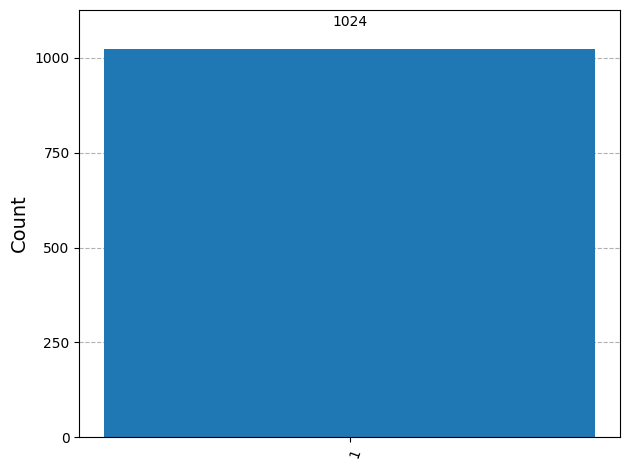

In [60]:
def noise_model(a,b,circuit):
  if not (0<=a<=1):
    print("Error: Probability invalid")
    return circuit
  for i in range(circuit.num_qubits):
    if (random.random()<=a):
      circuit.x(i)
  return circuit


qc = QuantumCircuit(1)
noise_model(.5,1.,qc)
qc.measure_all()

backend = AerSimulator()
tc = transpile(qc,backend)

result = backend.run(tc).result()
plot_histogram(result.get_counts(0))

LOOKY
1
executed
|0>
{'000': 1024}
000


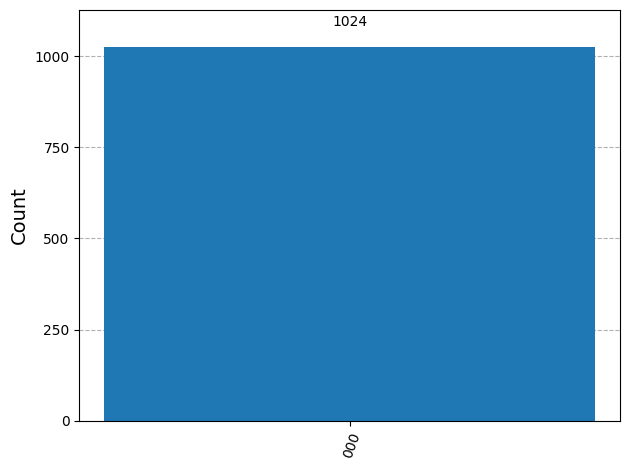

In [66]:
#Now, we apply the repetition code
#We encode |0> as |000> and |1> as |111>
#Additionally, we have 2 ancilla qubits to decode
#Finally, map q0 back to classical bit to get result

def repetition_code(circuit,a,b):
  qreg = QuantumRegister(5)
  creg = ClassicalRegister(3)
  qc = QuantumCircuit(qreg,creg)
  #since we're first dealing with 1 qubit case
  #q0 for the original
  #q1 and q2 as repeition
  #q3 and q4 as ancilla for measuring
  #3 classical --> 2 for ancilla, and 1 for output

  qc.compose(circuit, [0], inplace=True)
  qc.barrier

  #now comes the repetition
  #first, encode
  qc.cx(0,1)
  qc.cx(0,2)
  qc.barrier()

  #introduce the error
  noise_model(a,b,circuit)

  #now, encode the ancilla bits
  qc.cx(0,3)
  qc.cx(1,3)
  qc.cx(2,4)
  qc.cx(0,4)

  qc.measure([3,4], [0,1])
  #note
  #01 --> error in q2
  #10 -->error in q0
  #11 --> error in q1
  with qc.switch(creg) as c:
    with c(1):
      qc.x(2)
    with c(2):
      qc.x(0)
    with c(3):
      qc.x(1)

  #final step; measure
  qc.measure(0,2)

  #Let's now test it
  backend = AerSimulator()
  tc = transpile(qc,backend)
  result = backend.run(tc).result()
  print('executed')
  #return result

  zeroes = 0
  ones = 0

  for a in result.get_counts(0):
    if a[0] =='0':
      zeroes += result.get_counts(0)[a]
    else:
      ones += result.get_counts(0)[a]

  '''for bitstring, count in counts.items():
    fb = bitstring.split()[0] #only getting the logical qubit
    if fb =='0':
      zeroes +=1
    if fb=='1':
      ones +=1'''

  if zeroes>ones:
    print('|0>')
  else:
    print('|1>')
    print(zeroes)
    print(ones)
  return result

test = QuantumCircuit(1)
print('LOOKY')
print(test.num_qubits)
#noise_model(1.0,1.0,test)

result=repetition_code(test,0.5,1.0)
print(result.get_counts(0))
for a in result.get_counts(0):
  print(a)
plot_histogram(result.get_counts(0))


#print(type(result))

This is the implementation of repetition code, where for k qubits, we need
3k + 2 qubits to encode and decode. Although this is the easiest to understand and has a direct analogy in classical computing, it only accounts for errors in the x basis (and the difference is phase is not measurable), thus it can only account for x erros, and not z errors

In [ ]:
##Shor Code